# Neuro4ML Coursework 2

In this week's coursework, you will use a data set of spike trains recorded from monkey motor cortex while it was doing a task involving moving a pointer on a screen. The aim of this coursework is to decode the recorded velocity of the pointer from the neural data using a network of leaky integrate-and-fire neurons that take the recorded spikes as input and give sequences of velocities as outputs. You will train these networks using surrogate gradient descent. If you haven't already looked at it, a great starting point is Friedemann Zenke's [SPyTorch tutorial notebook 1](https://github.com/fzenke/spytorch/blob/main/notebooks/SpyTorchTutorial1.ipynb) (and the rest are worth looking at too).

In this coursework, we are following the general approach of the article ["Machine learning for neural decoding" (Glaser et al. 2020)](https://doi.org/10.1523/ENEURO.0506-19.2020), but using a spiking neural network decoder instead of the statistical and artificial neural network models used in that paper. You can also have a look at the [GitHub repository for the paper](https://github.com/KordingLab/Neural_Decoding). In case you're interested, the data were originally recorded for the paper ["Population coding of conditional probability distributions in dorsal premotor cortex" (Glaser et al. 2018)](https://doi.org/10.1038/s41467-018-04062-6), but you do not need to read this paper to understand this coursework.

The general setup is illustrated in this figure:

![Cartoon of decoder setup](cartoon.png)

You are given an array of ``num_neurons`` spike trains in a variable ``spike_trains``. This variable is a Python list of numpy arrays, each numpy array has a different length and is the recorded times (in seconds) that the corresponding neuron fired a spike. You also have two additional arrays ``vel`` and ``vel_times`` where ``vel`` has shape ``(num_time_points, 2)`` and ``vel_times`` has has shape ``(num_time_points)``. The second axis of ``vel`` has length 2 corresponding to the x and y-components of the recorded velocity.

## Setting up

This section has some basics to get you started.

Let's start by importing some libraries you can make use of. You can solve all the task only using the imports below, but you are welcome to add your own.

In [49]:
import pickle

import numpy as np
from scipy import io
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as tnnf
mse = nn.MSELoss()

from tqdm.notebook import tqdm

ms = 1e-3 # use this constant so you can write e.g. 1*ms for a time

You already have a copy of the raw data, but for your information, here is where the original can be downloaded.

In [50]:
import urllib.request, zipfile, os
filename = 's1_data_raw.mat'
if not os.path.exists(filename):
    urllib.request.urlretrieve('https://www.dropbox.com/sh/n4924ipcfjqc0t6/AACPWjxDKPEzQiXKUUFriFkJa?dl=1', 'data.zip')
    with zipfile.ZipFile('data.zip') as z:
        z.extract(filename)

## Task 1: Load and plot the data

The code below first loads the raw data, which is stored as a Matlab file, and then extracts the three arrays ``spike_times``, ``vel`` and ``vel_times``.

In [51]:
# Load the raw data
data = io.loadmat('s1_data_raw.mat') # a matlab file!
spike_times = [st[:, 0] for st in data['spike_times'].ravel()] # a list of arrays of spike times in seconds, one for each neuron, spike times in seconds
vel = data['vels'] # velocity data shape (num_time_points, 2) for (x, y) coordinates
vel_times = data['vel_times'].squeeze() # times the velocities were recorded

### Task 1A: Preprocess and compute basic statistics

In this task, you will preprocess the data, extract some basic statistics from it.

1. Whiten the recorded velocities (i.e. transform them so that their mean is 0 and standard deviation is 1).
2. Compute and print out the number of neurons and number of spikes recorded.
3. Compute and print out the duration of the experiment in seconds and/or minutes.
4. Compute and print out the sampling rate at which spikes were recorded (or find the information in the corresponding paper).
5. Compute and print out the sampling rate at which velocities were recorded (or find the information in the corresponding paper).

Note that the spikes and velocities were recorded with different equipment and so they have different sampling rates. Think about how you can estimate these sampling rates from the recorded data (or look it up in the paper).

In [52]:

# Calculate the mean of each column
mean = np.mean(vel, axis=0)

# Calculate the standard deviation of each column
std_dev = np.std(vel, axis=0)

# Subtract the mean and divide by the standard deviation
whitened_vel = (vel - mean) / std_dev
vel = whitened_vel

# duration
duration = vel_times[-1] - vel_times[0]

# total spikes across all the neurons
total_num_spikes = sum([len(times) for times in spike_times])

all_spike_times = []
for times in spike_times:
    all_spike_times.extend(times) # time gaps
    
print(f"Number of neurons: {len(spike_times)}")
print(f"Total number of spikes recorded across all neurons: {total_num_spikes}")
print(f"Duration of experiement: {duration} Seconds or {round((duration)/60,2)} Minutes")
print(f"Spike sampling rate {1 / round(np.mean(np.diff(all_spike_times)), 4)} Hz")
print(f"Velocity sampling rate {1 / round(np.mean(np.diff(vel_times)), 4)} Hz")



Number of neurons: 52
Total number of spikes recorded across all neurons: 1480032
Duration of experiement: 3066.99 Seconds or 51.12 Minutes
Spike sampling rate 476.1904761904762 Hz
Velocity sampling rate 100.0 Hz


### Task 1B: Plot the data

In this task, you will plot the data to get a feeling for what it is like (an important step in any modelling).

1. Plot the spike times as a raster plot (black dots at x-coordinates the time of the spike, and y-coordinates the index of the neuron). Plot this both for the whole data set and for the period from 1000 to 1010 seconds.
2. Plot the x- and y-coordinates of the velocities. Plot this both for the whole data set and for the same period as above for the spikes.
3. Compute the mean firing rate (number of spikes per second) for each neuron and display as a bar chart.
4. Plot the velocities as a curve in (x, y) space, emphasising the part of the velocity curve for the period above.

You can use the template below to get you started.

In [53]:
# plt.figure(figsize=(12, 5))

# # Plot all spikes
# ax = plt.subplot(231)
# # ...
# plt.ylabel('Neuron index')
# # Plot all x- and y- components of the velocities
# plt.subplot(234, sharex=ax)
# # ...
# plt.xlabel('Time (s)')
# plt.ylabel('velocity')
# plt.legend(loc='best')
# # Plot spikes at times t=1000 to t=1010
# ax = plt.subplot(232)
# # ...
# # Plot velocities at times t=1000 to t=1010
# plt.subplot(235, sharex=ax)
# plt.xlabel('Time (s)')

# # Compute firing rates for each neuron and plot as a histogram
# plt.subplot(233)
# firing_rates = ...
# plt.barh(range(len(spike_times)), firing_rates, height=1)
# plt.xlabel('Firing rate (sp/s)')
# plt.ylabel('Neuron index')

# # Plot all velocities as points in (x, y)-plane as a continuous curve
# # Emphasise the region from t=1000 to t=1010 with a different colour
# plt.subplot(236)
# # ...
# plt.xlabel('X velocity')
# plt.ylabel('Y velocity')

# plt.tight_layout();

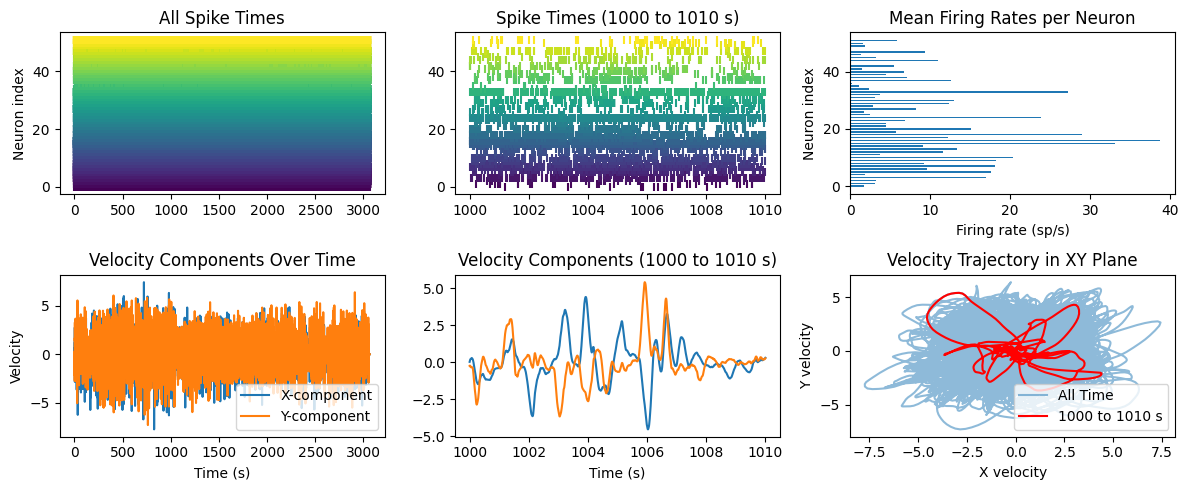

In [54]:
import matplotlib.cm as cm

plt.figure(figsize=(12, 5))
colors = cm.viridis(np.linspace(0, 1, len(spike_times)))  # Create a color map

# Plot all spikes
ax = plt.subplot(231)
for i, time in enumerate(spike_times):
    plt.scatter(time, [i] * len(time), c=[colors[i]], marker='|')
plt.ylabel('Neuron index')
plt.title('All Spike Times')

# Plot all x- and y-components of the velocities
plt.subplot(234, sharex=ax)
plt.plot(vel_times, vel[:, 0], label='X-component')
plt.plot(vel_times, vel[:, 1], label='Y-component')
plt.xlabel('Time (s)')
plt.ylabel('Velocity')
plt.legend(loc='best')
plt.title('Velocity Components Over Time')

# Plot spikes at times t=1000 to t=1010
ax = plt.subplot(232)
for i, time in enumerate(spike_times):
    valid_times = time[(time >= 1000) & (time <= 1010)]
    plt.scatter(valid_times, [i] * len(valid_times), c=[colors[i]], marker='|')
plt.title('Spike Times (1000 to 1010 s)')

# Plot velocities at times t=1000 to t=1010
plt.subplot(235, sharex=ax)
mask = (vel_times >= 1000) & (vel_times <= 1010)
plt.plot(vel_times[mask], vel[mask, 0], label='X-component')
plt.plot(vel_times[mask], vel[mask, 1], label='Y-component')
plt.xlabel('Time (s)')
plt.title('Velocity Components (1000 to 1010 s)')

# Compute firing rates for each neuron and plot as a histogram
plt.subplot(233)
firing_rates = [len(time) / (max(vel_times) - min(vel_times)) for time in spike_times]
plt.barh(range(len(spike_times)), firing_rates, height=0.5)
plt.xlabel('Firing rate (sp/s)')
plt.ylabel('Neuron index')
plt.title('Mean Firing Rates per Neuron')

# Plot all velocities as points in (x, y)-plane as a continuous curve
# Emphasise the region from t=1000 to t=1010 with a different colour
plt.subplot(236)
plt.plot(vel[:, 0], vel[:, 1], label='All Time', alpha=0.5)
plt.plot(vel[mask, 0], vel[mask, 1], label='1000 to 1010 s', color='red')
plt.xlabel('X velocity')
plt.ylabel('Y velocity')
plt.legend(loc='best')
plt.title('Velocity Trajectory in XY Plane')

plt.tight_layout()
plt.show()

## Task 2: Divide data into test/train and batches

1. As in any machine learning task, divide your data up into a non-overlapping training set, testing set and (optionally) validation set.
2. Write a generator function (see below) ``batched_data`` that iterates over your data in randomly ordered segments of a given length, returning it in batches. The function should have arguments that determine the range of data to use, the simulation time step that will be used, the length (in seconds) of each batch, and the batch size (you may add additional arguments if you wish). The function should return a pair of arrays ``(x, y)``. The array ``x`` has shape ``(batch_size, num_neurons, num_time_points)`` containing the spike times as an array where a zero indicates no spike and 1 indicates a spike. Here ``num_time_points`` is the number of time points in the batch measured at the sampling rate of the simulation time step, not the number of time points in the data as a whole, nor at the spike or velocity sampling rate. The array ``y`` has shape ``(batch_size, 2, num_time_points)`` containing the velocities at the same time points as the spikes. You will need to use some sort of interpolation to get the velocities at these times.
3. Plot a sample of spike times and velocities for a random batch of length 1 second and ``batch_size=4``.

**Note on generation functions**

Generator functions are an advanced feature of Python that makes it easy to iterate over complicated datasets. The general syntax is just a standard function that uses the keyword ``yield`` instead of ``return`` to return data, which allows it to return data multiple times. You can iterate over the values returned by a generator function instead of just calling it. Here's an example:

You can use the following template but you may want to define some additional helper functions to simplify your code and that you can re-use later.

X shape: torch.Size([4, 52, 1000])
Y shape: torch.Size([4, 2, 1000])


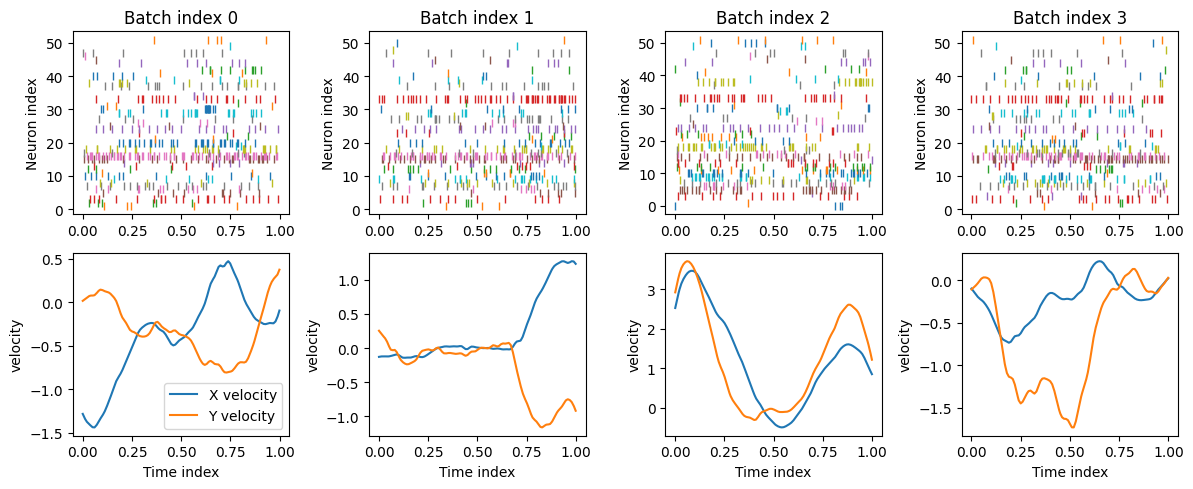

In [55]:
from scipy.interpolate import interp1d

# Set up training / validation / testing ranges
total_duration = vel_times[-1] - vel_times[0]
train_frac = 0.7
val_frac = 0.15
test_frac = 0.15

train_end = int(total_duration * train_frac)
val_end = train_end + int(total_duration * val_frac)

train_range = (0, train_end)
val_range = (train_end, val_end)
test_range = (val_end, int(total_duration))


import numpy as np
import torch
from scipy.interpolate import interp1d
import random

def prepare_batch(batch_segment, spike_times, vel_times, vel, dt, length, num_time_points):
    start_time = batch_segment
    time_points = np.linspace(start_time, start_time + length, num_time_points)  # 1 second long segment

    # Spike data preparation
    x_batch = torch.zeros((len(spike_times), num_time_points))
    for neuron_index, neuron_spikes in enumerate(spike_times):
        spike_times_in_batch = neuron_spikes[(neuron_spikes >= start_time) & (neuron_spikes < start_time + 1)]
        indices = np.floor((spike_times_in_batch - start_time) / dt).astype(int)
        x_batch[neuron_index, indices] = 1

    # Velocity interpolation
    interp_func = interp1d(vel_times, vel.T, kind='linear', bounds_error=False, fill_value="extrapolate")
    y_batch = torch.tensor(interp_func(time_points))

    return x_batch, y_batch

def batched_data(range_to_use, spike_times, vel, vel_times, dt=ms, length=1, batch_size=64, max_num_batches=40):
    start_time, end_time = range_to_use

    # Create segments each length seconds long
    segments = np.arange(start_time, end_time, length)
    random.shuffle(segments)  # Shuffle segments to randomize batch contents

    num_segments = len(segments)
    num_batches = min(num_segments // batch_size, max_num_batches)

    for batch_idx in range(num_batches):
        x = torch.zeros((batch_size, len(spike_times), int(length / dt)))
        y = torch.zeros((batch_size, 2, int(length / dt)))

        for b in range(batch_size):
            segment_index = batch_idx * batch_size + b
            if segment_index < num_segments:
                x_batch, y_batch = prepare_batch(segments[segment_index], spike_times, vel_times, vel, dt, length, int(length / dt))
                x[b] = x_batch
                y[b] = y_batch

        yield x, y

# Plot a sample of data

# Plot a sample of data
x, y = next(batched_data(train_range, spike_times, vel, vel_times, dt=ms, length=1, batch_size=4))
print(f"X shape: {x.shape}")
print(f"Y shape: {y.shape}")
plt.figure(figsize=(12, 5))
for b in range(4):
  # Plot spikes for this batch index
  ax = plt.subplot(2, 4, b+1)
  for neuron_idx in range(x.shape[1]):  # x.shape[1] will give num neurons in the tensor
      spike_times_batch = np.where(x[b, neuron_idx].numpy() == 1)[0] * ms  # dt=ms
      plt.plot(spike_times_batch, [neuron_idx]*len(spike_times_batch), '|')
  plt.ylabel('Neuron index')
  plt.title(f'Batch index {b}')
  # Plot velocities for this batch index
  plt.subplot(2, 4, b+5, sharex=ax)
  time_axis = np.arange(0, x.shape[2]*1e-3, 1e-3)  
  plt.plot(time_axis, y[b, 0].numpy(), label='X velocity')
  plt.plot(time_axis, y[b, 1].numpy(), label='Y velocity')
  plt.xlabel('Time index')
  plt.ylabel('velocity')
  if b==0:
    plt.legend(loc='best')
plt.tight_layout();

## Surrogate gradient descent spike function

Below is the code for the surrogate gradient descent function from lectures. You can use it as is, although note that there is a hyperparameter (scale) that you can experiment with if you choose.

In [56]:
class SurrogateHeaviside(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrogateHeaviside.scale*torch.abs(input)+1.0)**2
        return grad

# here we overwrite our naive spike function by the "SurrogateHeaviside" nonlinearity which implements a surrogate gradient
surrogate_heaviside  = SurrogateHeaviside.apply

## Task 3: Simulation code

Write modular code to simulate a layer of leaky integrate-and-fire spiking neurons compatible with autodifferentiation with PyTorch. You can either write this as a function or class. The code should accept an input batch of spikes ``x`` of shape ``(batch_size, num_input_neurons, num_time_points)`` and values 0 or 1 (as in the ``batched_data`` generator function above). The code should have the option to produce either spiking or non-spiking output. In both cases, the output should be an array ``y`` of shape ``(batch_size, num_output_neurons, num_time_points)``. In the case of spiking output, the values of ``y`` should be 0s and 1s, and in the case of non-spiking output they should be the membrane potential values. You may also want to write an additional class to handle multiple layers of spiking neural networks for subsequent tasks.

Your code should include initialisation of the weight matrices, and add additional hyperparameters for this initialisation. You may also want to make the time constants of your neurons into hyperparameters. I used ``tau=50*ms`` for spiking neurons and ``tau=500*ms`` for non-spiking neurons and it worked OK, but I didn't do an extensive hyperparameter search.

I would recommend approaching this and the following sections as follows:

1. Write simulation code for a single layer, non-spiking neural network first. This code is simpler and will train fast (under 3 minutes on Colab). Attempt as much of the remaining tasks as possible using only this.
2. Add the ability for spiking and test that your code produces reasonable output but don't try to train it yet.
3. Add the ability to plot spiking hidden layers and try to get a reasonable initialisation of the network.
4. Start training the spiking neural network. Your final run will probably take a long time to train but you should build up to that by seeing how well the training curves improve for fewer epochs, batch sizes, etc.

You can use the template below if you want to use the class-based approach.

In [57]:
class SNNLayer(nn.Module):
    def __init__(self, n_in, n_out, spiking=True, tau=50, threshold=1):
        super(SNNLayer, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.spiking = spiking
        self.tau = tau
        self.threshold = threshold

        # Store weights as a trainable parameter
        self.w = nn.Parameter(torch.empty(n_in, n_out))
        nn.init.normal_(self.w, mean=0.0, std=8000)  

    def forward(self, x):
        batch_size, _, num_time_points = x.shape
        v = torch.zeros(batch_size, self.n_out, device=x.device)
        output = torch.zeros(batch_size, self.n_out, num_time_points, device=x.device)

        for t in range(num_time_points):
            # Compute input from pre-synaptic neurons
            current_input = torch.matmul(x[:, :, t], self.w)

            # Update membrane potentials with decay and input
            dv = (-v + current_input) / self.tau
            v += dv * ms

            if self.spiking:
                # Check for neurons exceeding threshold
                spikes = (v >= self.threshold).float()
                output[:, :, t] = spikes  # Record spikes
                v = v * (1 - spikes) # Reset voltage where spikes occurred
            else:
                output[:, :, t] = v  # Record potentials for non-spiking case

        return output

## Task 4: Evaluation functions

Write code that takes a network and testing range as input and returns the mean loss over the testing data. The loss is the mean squared error of the output of the network compared to the target data. You may also find it helpful to compute the null loss, which is the loss you would get if you just output all zeros. You should be able to do better than this!

Also write code that plots some of the internal outputs of the network, for example to show you the spikes produced by hidden layers, calculate their firing rates, etc.

Initialise a network with one hidden layer of 100 spiking neurons and one output layer of 2 non-spiking neurons. Run this on a random sample of the data of length 1 and plot the input spikes, hidden layer spikes, output x- and y-velocities, and the data x- and y-velocities. For each spiking layer compute the firing rates of each neuron and plot them as a histogram.

You can use this to initialise your networks in a reasonable state. Hidden layers should fire spikes at rates that are not too low and not too high. I aimed for an average firing rate in the range 20-100 and it worked well, but you can experiment with other options. The output layer should give values that are roughly in the right range as the data (i.e. it shouldn't go to +/- 100 if the data is going to only +/- 4). If you look at the spike trains of your hidden layer and all the neurons at initialisation are doing exactly the same thing then it's probably not going to learn very well, so try out some different weight initialisations to see if you can do better.

Print the value of the loss (and optionally the null loss) for your untrained network, to give you an idea of the baseline.

You may want to wrap your evaluation code in a ``with`` statement like below to stop PyTorch from computing gradients when evaluating (unnecessary and expensive):

```python
with torch.no_grad():
    ...
    # whatever you do here won't compute any gradients
```

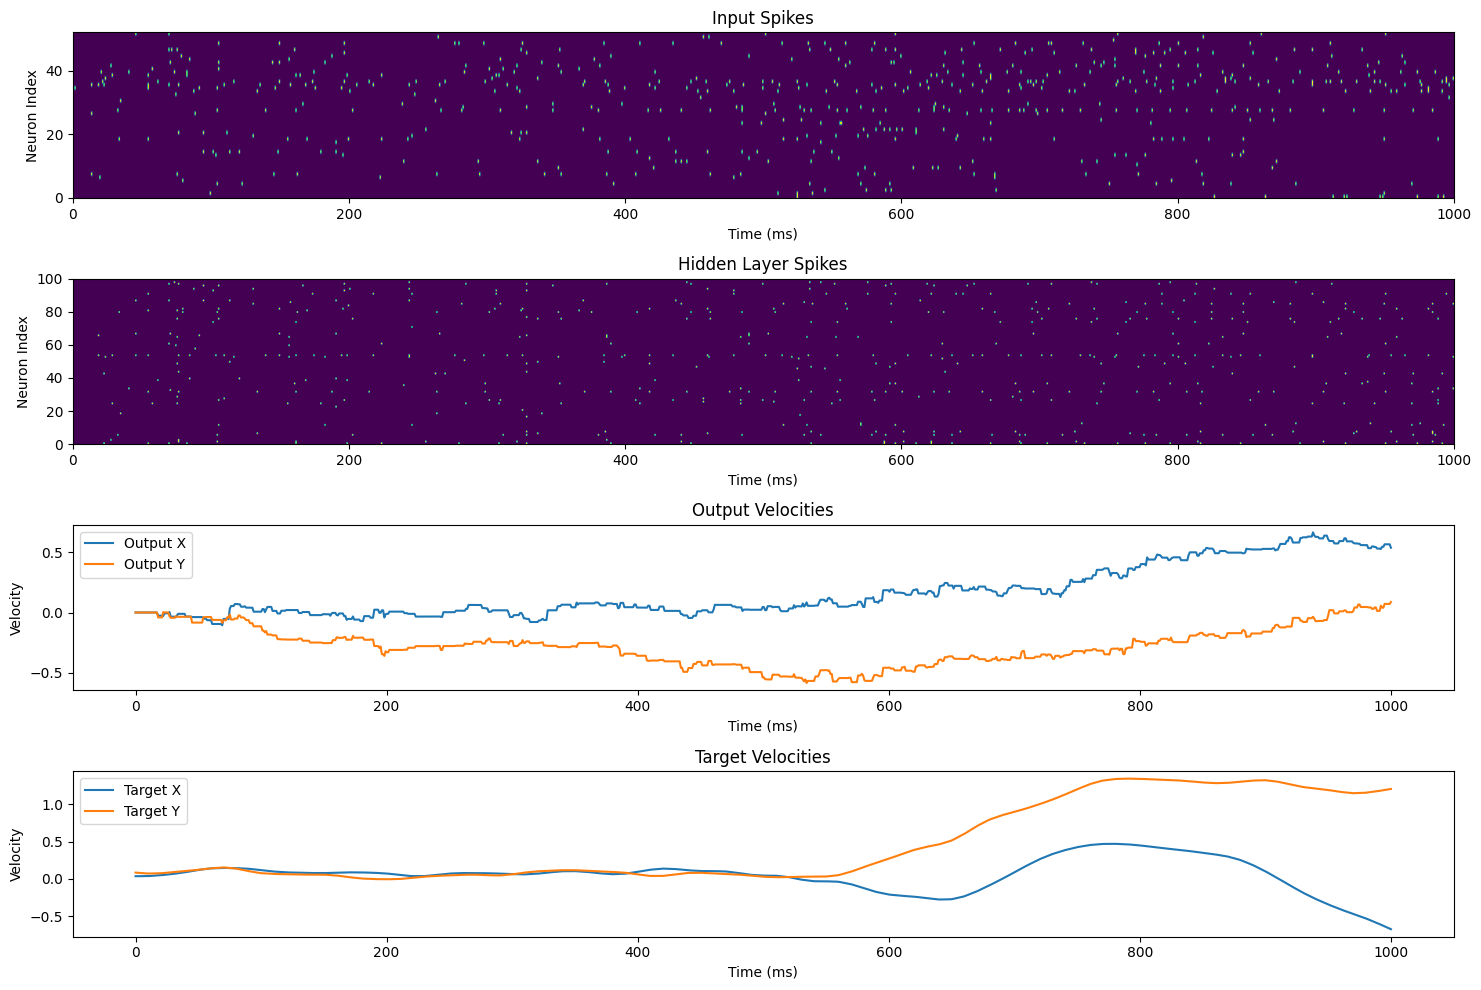

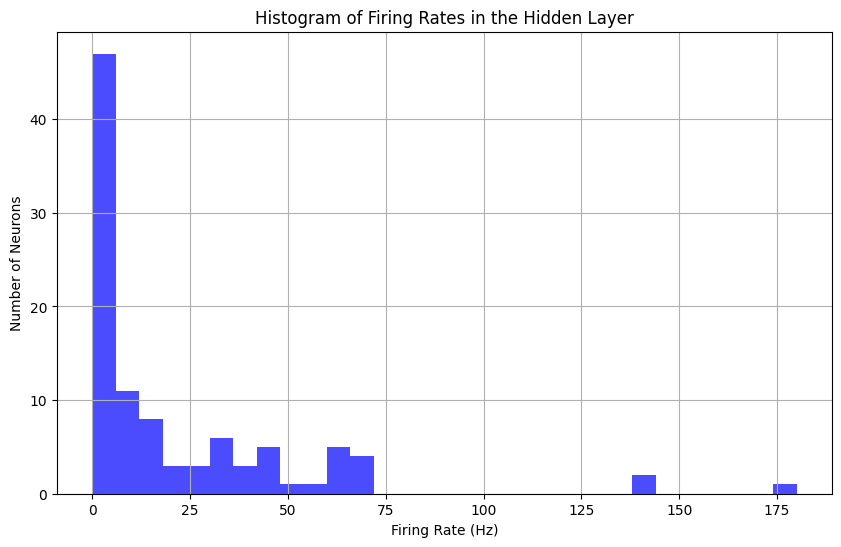

Loss: 1.0301672220230103, Null Loss: 0.7957373857498169
Hidden layer mean firing rate: 20.71 Hz


In [58]:
import torch.nn.functional as F

class SimpleSNN(nn.Module):
    def __init__(self):
        super(SimpleSNN, self).__init__()
        self.hidden_layer = SNNLayer(n_in=52, n_out=100, spiking=True)
        self.output_layer = SNNLayer(n_in=100, n_out=2, spiking=False, tau=500)

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        return x

def evaluate_model(network, test_loader):
    total_loss = 0.0
    null_loss = 0.0
    count = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = network(inputs)
            loss = F.mse_loss(outputs, targets)
            total_loss += loss.item()

            # Compute null loss: the loss if the network outputted zeros
            null_output = torch.zeros_like(outputs)
            null_loss += F.mse_loss(null_output, targets).item()

            count += 1

    return total_loss / count, null_loss / count

# Function to load and process data from the test range
def load_test_data(test_range, spike_times, vel, vel_times, dt=ms, length=1, batch_size=4):
    test_data_generator = batched_data(test_range, spike_times, vel, vel_times, dt, length, batch_size)
    return next(test_data_generator)  # For example, just take the first batch for now

def compute_firing_rates(hidden_spikes, dt):
    # Sum over all time points to get the total number of spikes for each neuron
    total_spikes_per_neuron = hidden_spikes.sum(dim=2)
    # Sum over batches to integrate spikes from all test examples
    total_spikes_per_neuron = total_spikes_per_neuron.sum(dim=0)
    # Compute the total time duration covered by the spikes
    total_time_seconds = hidden_spikes.size(2) * dt
    # Compute firing rates: spikes per second (Hz) per neuron
    firing_rates = total_spikes_per_neuron / total_time_seconds
    return firing_rates

def plot_firing_rates(firing_rates):
    plt.figure(figsize=(10, 6))
    plt.hist(firing_rates.numpy(), bins=30, color='blue', alpha=0.7)
    plt.title('Histogram of Firing Rates in the Hidden Layer')
    plt.xlabel('Firing Rate (Hz)')
    plt.ylabel('Number of Neurons')
    plt.grid(True)
    plt.show()

def plot_network_activity(inputs, hidden_outputs, outputs, targets, dt=ms):
    num_time_points = inputs.shape[-1]  
    time_in_ms = np.linspace(0, num_time_points * dt * 1000, num_time_points)  # Convert seconds to milliseconds

    plt.figure(figsize=(15, 10))

    # Input Spikes
    plt.subplot(4, 1, 1)
    plt.imshow(inputs[0].numpy(), aspect='auto', extent=[0, time_in_ms[-1], 0, inputs.shape[1]])
    plt.title('Input Spikes')
    plt.ylabel('Neuron Index')
    plt.xlabel('Time (ms)')

    # Hidden Layer Spikes
    plt.subplot(4, 1, 2)
    plt.imshow(hidden_outputs[0].numpy(), aspect='auto', extent=[0, time_in_ms[-1], 0, hidden_outputs.shape[1]])
    plt.title('Hidden Layer Spikes')
    plt.ylabel('Neuron Index')
    plt.xlabel('Time (ms)')

    # Output Velocities
    plt.subplot(4, 1, 3)
    plt.plot(time_in_ms, outputs[0][0].numpy(), label='Output X')
    plt.plot(time_in_ms, outputs[0][1].numpy(), label='Output Y')
    plt.title('Output Velocities')
    plt.ylabel('Velocity')
    plt.xlabel('Time (ms)')
    plt.legend()

    # Target Velocities
    plt.subplot(4, 1, 4)
    plt.plot(time_in_ms, targets[0][0].numpy(), label='Target X')
    plt.plot(time_in_ms, targets[0][1].numpy(), label='Target Y')
    plt.title('Target Velocities')
    plt.ylabel('Velocity')
    plt.xlabel('Time (ms)')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Using the function to get test spikes and velocities
test_spikes, test_velocities = load_test_data(test_range, spike_times, vel, vel_times)
test_loader = [(test_spikes, test_velocities)]

network = SimpleSNN()
loss, null_loss = evaluate_model(network, test_loader)

# Run the network on test data
with torch.no_grad():
    hidden_spikes = network.hidden_layer(test_spikes)
    outputs = network(test_spikes)

# Calculate firing rates
firing_rates = compute_firing_rates(hidden_spikes, dt=0.001)  # Ensure dt is defined correctly

# Plot everything
plot_network_activity(test_spikes, hidden_spikes, outputs, test_velocities)
plot_firing_rates(firing_rates)

# Print loss and firing rates information
print(f"Loss: {loss}, Null Loss: {null_loss}")
print(f"Hidden layer mean firing rate: {firing_rates.mean().item():.2f} Hz")


## Task 5: Training

Start with a single non-spiking output layer (i.e. spikes connected directly via a weight matrix to two non-spiking LIF neurons as output). Find a good initialisation for this network that gives outputs roughly in the right range.

Select an optimisation algorithm, learning rate, etc. and train your network.

Has your algorithm converged?

You should be able to do better than the null loss (but you don't need to do hugely better). I get a null loss of around 0.8 and a trained loss of around 0.6.

At the end of training, plot your loss curves for training and test/validation data and print out your testing loss. Plot the output of your model and compare to the target data for 8 randomly sampled time windows of length 1. You may notice that your network matches the data better in the second half of the window than the first half, because the network always starts at a value zero even if the data doesn't. We'll look into this more in the next task. Don't worry too much if the fits don't look great at this stage. If you get a mean squared error of around .75 of the null MSE then you're doing fine.

You may want to use the following code as a starting point (it worked well enough for me but you can probably do better). On my desktop with CPU only, this took about two minutes to train.

In [59]:
# # Training parameters
# lr = 0.001 # learning rate
# num_epochs = 10
# max_num_batches = 40
# length = 1
# batch_size = 32 # small batches worked better for me for some reason

# # Optimiser and loss function
# optimizer = torch.optim.Adam(..., lr=lr) # what should the first argument be?

# # Training
# loss_hist = []
# val_loss_hist = []
# with tqdm(total=num_epochs*max_num_batches) as pbar:
#   last_epoch_loss = val_loss = null_val_loss = None
#   for epoch in range(num_epochs):
#     local_loss = []
#     for x, y in batched_data(...):
#       # Run the network
#       y_out = net(x)
#       # Compute a loss
#       loss = mse(y_out, y)
#       local_loss.append(loss.item())
#       # Update gradients
#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()
#       pbar.update(1)
#       pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, loss=loss.item(), val_loss=val_loss, null_val_loss=null_val_loss)
#     last_epoch_loss = np.mean(local_loss)
#     val_loss, null_val_loss = evaluate_network(net, ...)
#     pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, loss=loss.item(), val_loss=val_loss, null_val_loss=null_val_loss)
#     loss_hist.append(last_epoch_loss)
#     val_loss_hist.append(val_loss)

# # Plot the loss function over time
# plt.semilogy(loss_hist, label='Testing loss')
# plt.semilogy(val_loss_hist, label='Validation loss')
# plt.axhline(null_val_loss, ls='--', c='r', label='Null model loss')
# plt.xlabel('Epoch')
# plt.ylabel('MSE')
# plt.legend(loc='best')
# plt.tight_layout()

# testing_loss, null_testing_loss = evaluate_network(net, testing_range, length=length, batch_size=batch_size)
# print(f'{testing_loss=}, {null_testing_loss=}')

# # Plot trained output
# plt.figure(figsize=(16, 6))
# with torch.no_grad():
#   for x, y in batched_data(..., batch_size=8, max_num_batches=1):
#     for b in range(8):
#       plt.subplot(2, 4, b+1)
#       y_out = net(x)
#       plt.plot(y_out[b, 0, :], ':C0', label='x_out')
#       plt.plot(y_out[b, 1, :], ':C1', label='y_out')
#       plt.plot(y[b, 0, :], '--C0', label='x')
#       plt.plot(y[b, 1, :], '--C1', label='y')
#       # Plot a smoothed version as well
#       plt.plot(savgol_filter(y_out[b, 0, :], 151, 3), '-C0', label='x_out (smooth)')
#       plt.plot(savgol_filter(y_out[b, 1, :], 151, 3), '-C1', label='y_out (smooth)')
#       plt.ylim(-5, 5)
# plt.tight_layout();

  0%|          | 0/400 [00:00<?, ?it/s]

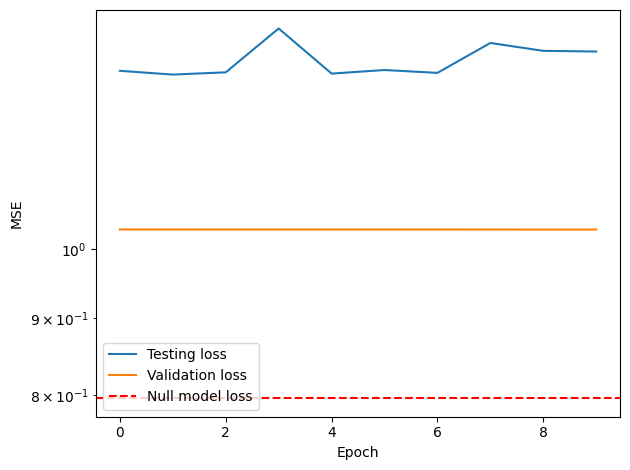

Testing loss=1.0300654172897339, Null testing loss=0.7957373857498169


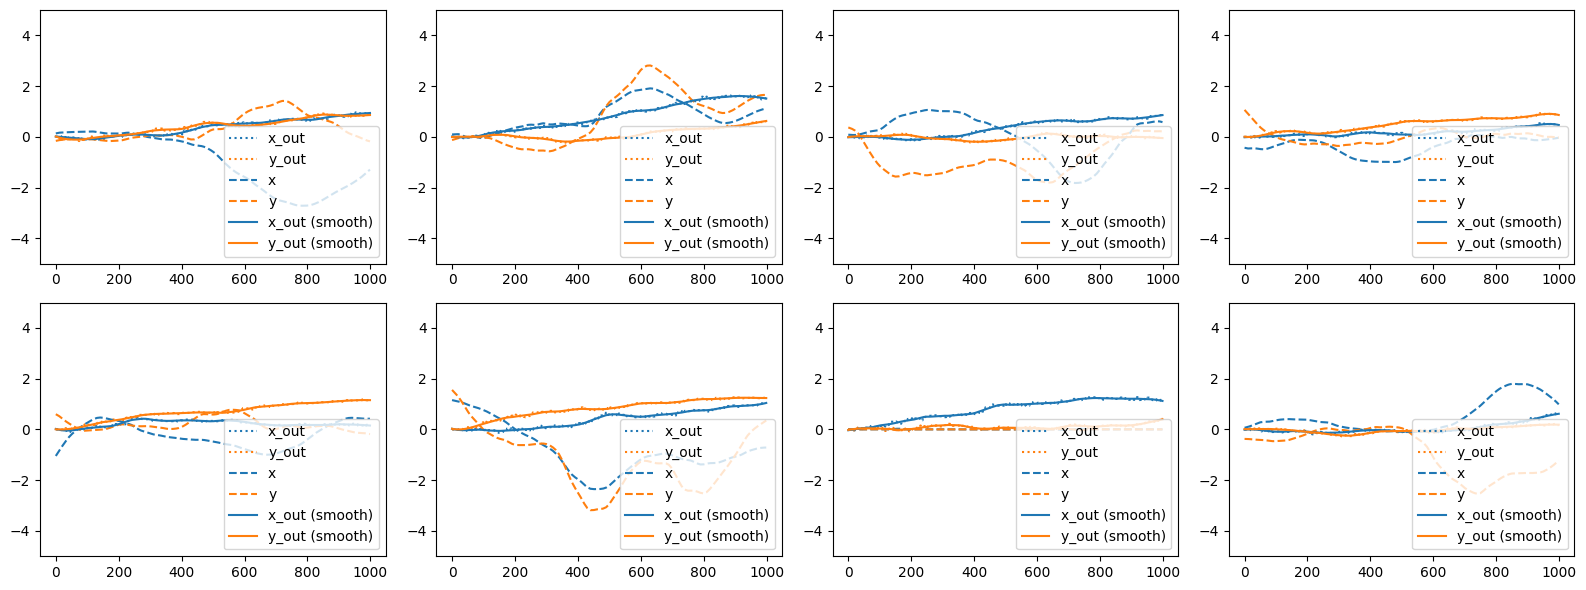

In [60]:
# Training parameters
lr = 0.001  # learning rate
num_epochs = 10
max_num_batches = 40
length = 1
batch_size = 32  # small batches worked better in some cases


# Optimizer and loss function setup
optimizer = torch.optim.Adam(network.parameters(), lr=lr)  # network is your model instance
loss_function = torch.nn.MSELoss()

# Training and validation loss history
loss_hist = []
val_loss_hist = []

# Training loop
with tqdm(total=num_epochs * max_num_batches) as pbar:
    last_epoch_loss = val_loss = null_val_loss = None
    for epoch in range(num_epochs):
        local_loss = []
        for x, y in batched_data(train_range, spike_times, vel, vel_times, batch_size=batch_size, max_num_batches=max_num_batches):
            # Run the network
            y_out = network(x)
            # Compute a loss
            loss = loss_function(y_out, y)
            local_loss.append(loss.item())
            # Update gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.update(1)
            pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, loss=loss.item(), val_loss=val_loss, null_val_loss=null_val_loss)
        last_epoch_loss = np.mean(local_loss)
        # Dummy evaluation function for simplicity, replace with actual
        val_loss, null_val_loss = evaluate_model(network, test_loader)
        loss_hist.append(last_epoch_loss)
        val_loss_hist.append(val_loss)
        pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, loss=loss.item(), val_loss=val_loss, null_val_loss=null_val_loss)

# Plot the loss function over time
plt.figure()
plt.semilogy(loss_hist, label='Testing loss')
plt.semilogy(val_loss_hist, label='Validation loss')
plt.axhline(null_val_loss, ls='--', c='r', label='Null model loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Final testing and null loss evaluation
testing_loss, null_testing_loss = evaluate_model(network, test_loader)
print(f'Testing loss={testing_loss}, Null testing loss={null_testing_loss}')

# Plot trained output
plt.figure(figsize=(16, 6))
with torch.no_grad():
    for x, y in batched_data(test_range, spike_times, vel, vel_times, batch_size=8, max_num_batches=1):
        y_out = network(x)
        for b in range(8):
            plt.subplot(2, 4, b+1)
            plt.plot(y_out[b, 0, :], ':C0', label='x_out')
            plt.plot(y_out[b, 1, :], ':C1', label='y_out')
            plt.plot(y[b, 0, :], '--C0', label='x')
            plt.plot(y[b, 1, :], '--C1', label='y')
            # Plot a smoothed version as well
            plt.plot(savgol_filter(y_out[b, 0, :], 151, 3), '-C0', label='x_out (smooth)')
            plt.plot(savgol_filter(y_out[b, 1, :], 151, 3), '-C1', label='y_out (smooth)')
            plt.ylim(-5, 5)
            plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Task 6: Longer length decoding

Your code above probably doesn't look great when plotted. That's partly because the outputs start at 0 but the data doesn't necessarily have to, so it takes a while for them to get in sync, and partly because on some intervals it will just do badly. To fix this, and to extend the fit to a longer range of data, in this task we only use the final timestep of each segment and compare to the data. Take a 15 second segment of testing data, and sample every 0.2 seconds to get 75 data points. For each data point, take a 1 second segment of time before this data point (these will be overlapping), run your simulation for that one second, and use the final time point of the simulated output as your prediction. Plot this compared to the real data for 8 different segments of 15 seconds.

This should look like a reasonable fit to the data. Congratulations, you have used raw spiking output of neurons recorded from a monkey's brain to predict what it was doing on a computer screen it was interacting with. That's a brain machine interface right here.

You can use the template below to get you started.

Your results might look something like this:

![Fits](fits.png)

In [273]:
# def decoding_plot(decoding_range, dt_decoding=0.2, decoding_length=15, length=1, dt=1e-3, figdims=(4, 2), ...):
#     w_intervals = np.arange(decoding_range[0]+length, decoding_range[0]+length+decoding_length, dt_decoding)
#     batch_size_single = len(w_intervals)-1
#     num_time_points = int(np.round(length/dt))
#     nfx, nfy = figdims
#     nf = nfx*nfy
#     batch_size = nf*batch_size_single
#     nrows = nfy*2
#     ncols = nfx
#     with torch.no_grad():
#         x = torch.zeros((batch_size, num_neurons, num_time_points))
#         y = torch.zeros((batch_size, 2, num_time_points))
#         T = []
#         for b in range(batch_size):
#            w_start = decoding_range[0]+dt_decoding*b
#            w_end = w_start+length
#            T.append(w_end)
#            # ... (copy data to x, y)
#         T = np.array(T)
#         y_out = ...
#         mean_mse = mse(y, y_out)
#         plt.figure(figsize=(ncols*3, nrows*2))
#         for nf_i in range(nf):
#             sp_x = nf_i % nfx
#             sp_y = nf_i // nfx
#             for i in range(2):
#                 plt.subplot(nrows, ncols, sp_x+1+2*ncols*sp_y+i*ncols)
#                 # ...
#                 plt.ylim(-4, 4)
#                 if sp_x==0:
#                     plt.ylabel('Velocity')
#                 if 2*sp_y+i==nrows-1:
#                     plt.xlabel('Time (s)')
#                 if nf_i==0:
#                     plt.legend(loc='best')
#         plt.suptitle(f'{mean_mse=:.3f}')
#         plt.tight_layout()

# decoding_plot()

## Task 7: Comparing spiking and non-spiking

Now try training your network with at least one spiking hidden layer. Compare your results to the non-spiking version. Note that training times with a spiking hidden layer are likely to be much longer. My training time went up from 2 minutes to 30 minutes (with CPU only).

With the spiking layer do you do worse, as well, or better? (There is no correct answer here, but if you can do much better let me know we might be able to write a paper on this.)